In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA



sns.set_style('darkgrid')


In [2]:
df = pd.read_csv('vehicle.csv')

In [3]:
df.head()

compactness  circularity  distance_circularity  radius_ratio  \
0           95         48.0                  83.0         178.0   
1           91         41.0                  84.0         141.0   
2          104         50.0                 106.0         209.0   
3           93         41.0                  82.0         159.0   
4           85         44.0                  70.0         205.0   

   pr.axis_aspect_ratio  max.length_aspect_ratio  scatter_ratio  \
0                  72.0                       10          162.0   
1                  57.0                        9          149.0   
2                  66.0                       10          207.0   
3                  63.0                        9          144.0   
4                 103.0                       52          149.0   

   elongatedness  pr.axis_rectangularity  max.length_rectangularity  \
0           42.0                    20.0                        159   
1           45.0                    19.0                        143   
2           32.0                    23.0                        158   
3           46.0                    19.0                        143   
4           45.0                    19.0                        144   

   scaled_variance  scaled_variance.1  scaled_radius_of_gyration  \
0            176.0              379.0                      184.0   
1            170.0              330.0                      158.0   
2            223.0              635.0                      220.0   
3            160.0              309.0                      127.0   
4            241.0              325.0                      188.0   

   scaled_radius_of_gyration.1  skewness_about  skewness_about.1  \
0                         70.0             6.0              16.0   
1                         72.0             9.0              14.0   
2                         73.0            14.0               9.0   
3                         63.0             6.0              10.0   
4                        127.0             9.0              11.0   

   skewness_about.2  hollows_ratio class  
0             187.0            197   van  
1             189.0            199   van  
2             188.0            196   car  
3             199.0            207   van  
4             180.0            183   bus

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 846 entries, 0 to 845
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   compactness                  846 non-null    int64  
 1   circularity                  841 non-null    float64
 2   distance_circularity         842 non-null    float64
 3   radius_ratio                 840 non-null    float64
 4   pr.axis_aspect_ratio         844 non-null    float64
 5   max.length_aspect_ratio      846 non-null    int64  
 6   scatter_ratio                845 non-null    float64
 7   elongatedness                845 non-null    float64
 8   pr.axis_rectangularity       843 non-null    float64
 9   max.length_rectangularity    846 non-null    int64  
 10  scaled_variance              843 non-null    float64
 11  scaled_variance.1            844 non-null    float64
 12  scaled_radius_of_gyration    844 non-null    float64
 13  scaled_radius_of_gyr

In [5]:
print(f'Total number of missing values = {df.isna().sum().sum()}')
df.isna().sum()

Total number of missing values = 41


compactness                    0
circularity                    5
distance_circularity           4
radius_ratio                   6
pr.axis_aspect_ratio           2
max.length_aspect_ratio        0
scatter_ratio                  1
elongatedness                  1
pr.axis_rectangularity         3
max.length_rectangularity      0
scaled_variance                3
scaled_variance.1              2
scaled_radius_of_gyration      2
scaled_radius_of_gyration.1    4
skewness_about                 6
skewness_about.1               1
skewness_about.2               1
hollows_ratio                  0
class                          0
dtype: int64

In [6]:
# !pip install missingpy
from missingpy import MissForest

imputer = MissForest(max_iter=10, decreasing=False, missing_values=np.nan,
             copy=True, n_estimators=100, criterion=('mse', 'gini'))

df_imputed = imputer.fit_transform(df.drop(columns = 'class'))

C:\Users\Drogon\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4


In [7]:
# the imputer returns an nd array
#To work with the data further, convert the nd array back to a dataframe and append the 'class' column

df = pd.concat([pd.DataFrame(df_imputed, columns= df.drop(columns = 'class').columns), df['class']], axis = 1)

In [8]:
print(f'Number of missing values after imputation = {df.isna().sum().sum()}')

Number of missing values after imputation = 0


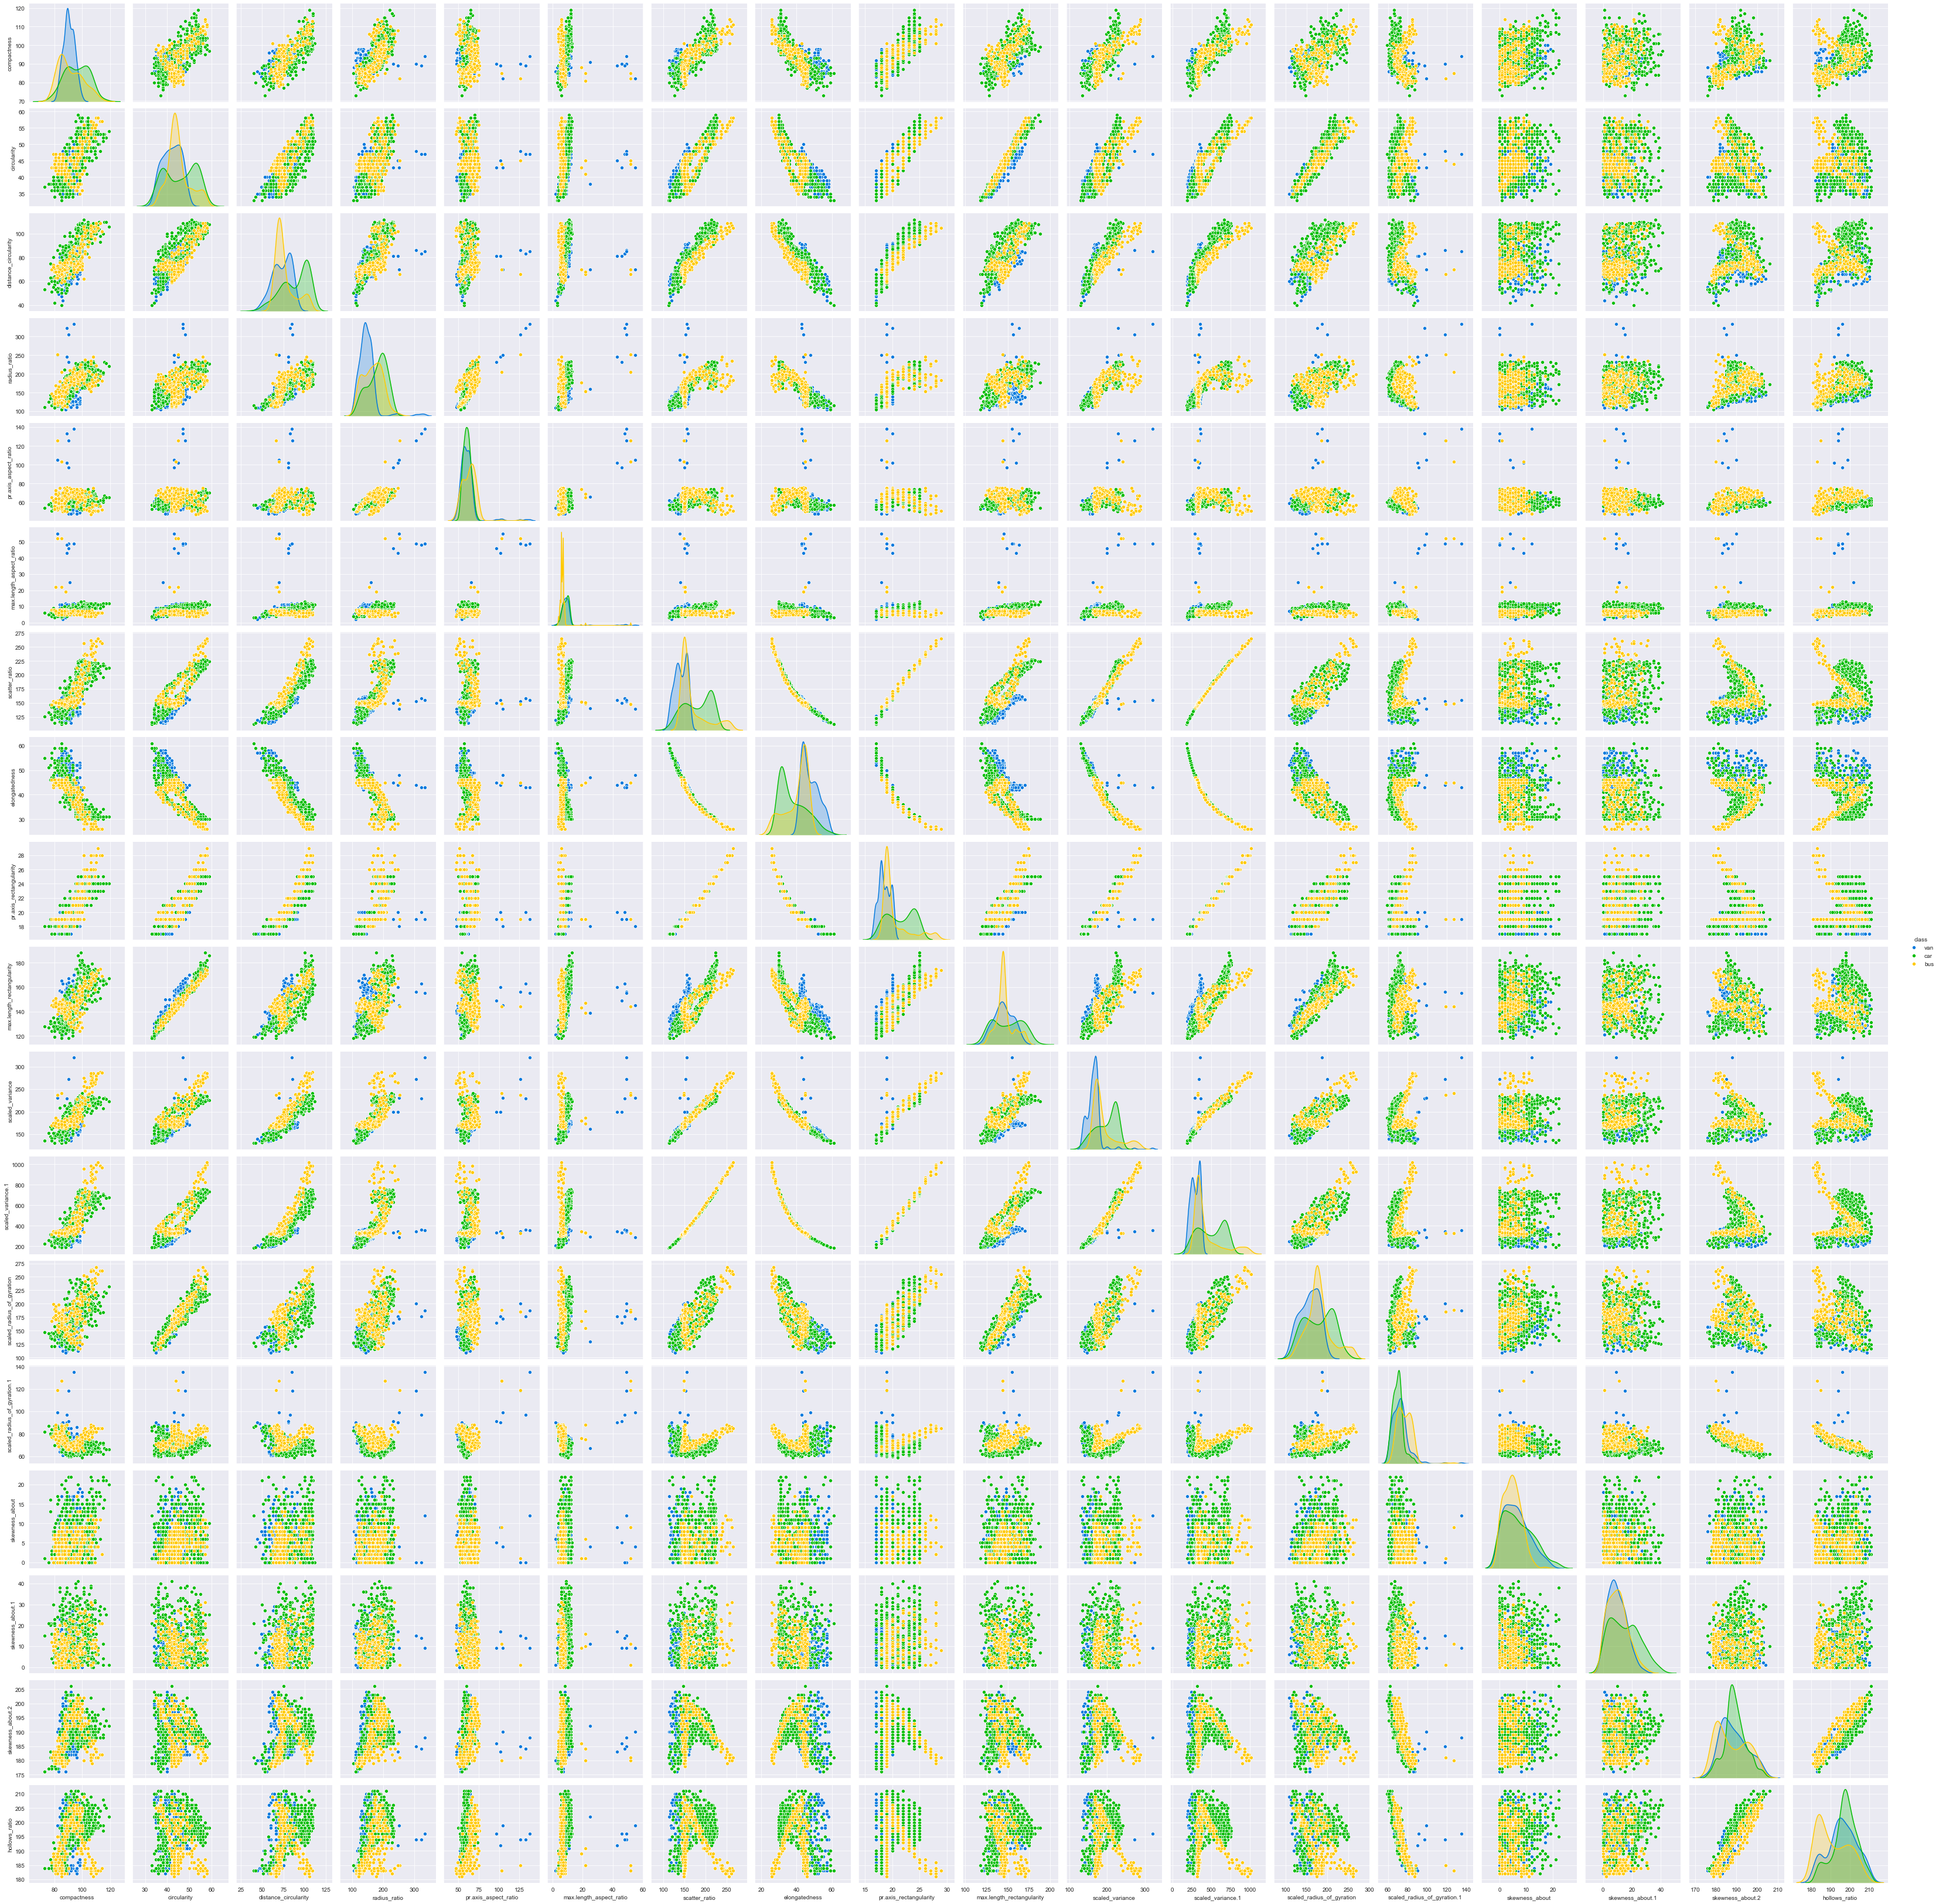

In [9]:
sns.pairplot(df, hue = 'class', diag_kind = 'kde', palette='nipy_spectral')
plt.show()

- There are a lot of peculiar shapes in the scatterplots to ponder upon
- Few scatter plots show heavy correlation amongst attributes
- Looking at the distributions along the diagonal, we can observe there are a few dimensions(predictors) along which there is some decent amount of seperation between the three class distributions. That is to say they are ponentially good predictors of the dependant variable

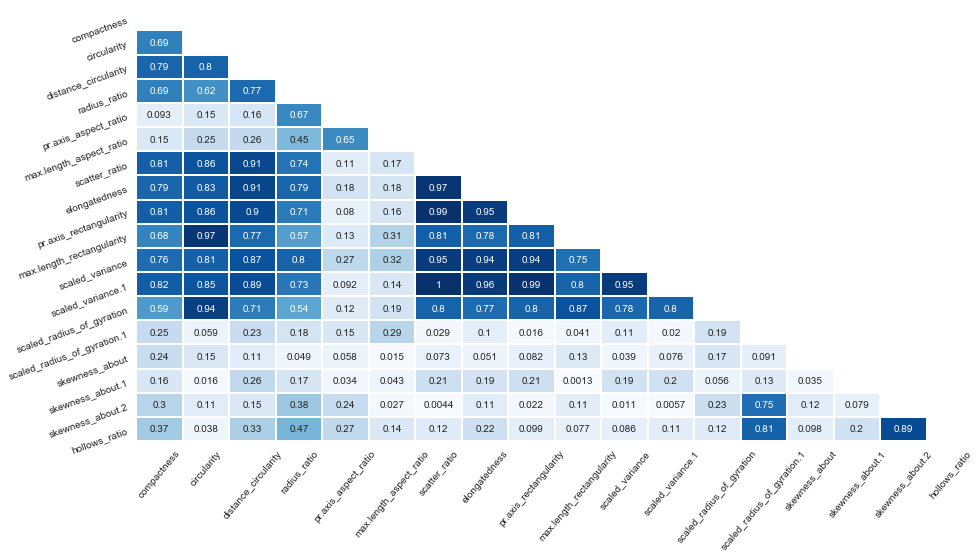

In [10]:
corr = abs(df.corr()) # correlation matrix
lower_triangle = np.tril(corr, k = -1)  # select only the lower triangle of the correlation matrix
mask = lower_triangle == 0  # to mask the upper triangle in the following heatmap

plt.figure(figsize = (15,8))  # setting the figure size
sns.set_style(style = 'white')  # Setting it to white so that we do not see the grid lines
sns.heatmap(lower_triangle, center=0.5, cmap= 'Blues', annot= True, xticklabels = corr.index, yticklabels = corr.columns,
            cbar= False, linewidths= 1, mask = mask)   # Da Heatmap
plt.xticks(rotation = 50)   # Aesthetic purposes
plt.yticks(rotation = 20)   # Aesthetic purposes
plt.show()

- Quiet evidently, few dependant variables are correlated heavily amongst themselves example, 'scatter_ratio' and 'scaled_variance.1'  have a 100% correlation
- For now instead of dropping any variables, we will carry on with the exercise and see how we can use PCA to deal with this

**Note:** All the variables are not on the same scale hence before visualizing all of them together using box plots, we will scale the data.

Because we are using a supervised model in the end, we want to avoid any potential data leakage. Hence, we will be scaling the data seperately for test and train. Similarly we will generate Principle components only from the train data and later transform the test data

In [11]:
X = df.drop(columns='class')
y = df['class']

In [12]:
from sklearn.preprocessing import StandardScaler    # to scale the data
from sklearn.model_selection import train_test_split  # to split the data into test and train sets

scaler = StandardScaler()   # creating a scaler object

'''To avoid data leakage, we will fit the scaler object using the train set and then transform the train and test sets using
the fitted Scaler object'''

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state = 1,
                                                    stratify = y)# Stratify y to keep the class proportions consistent

scaler.fit(X_train)  # fitting the scaler object using the train data

X_train_scaled = scaler.transform(X_train)  # transform the train set
X_test_scaled = scaler.transform(X_test)    # transform the test set

'''Because .transform returns nd arrays, assigning them back to the respective dataframes to retain dataframe structure,
but with scaled values'''

X_train.loc[:,:] = X_train_scaled 
X_test.loc[:,:] = X_test_scaled

C:\Users\Drogon\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Drogon\anaconda3\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Drogon\anaconda3\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [13]:
train = pd.concat([X_train, y_train], axis = 1)
test = pd.concat([X_test, y_test], axis = 1)

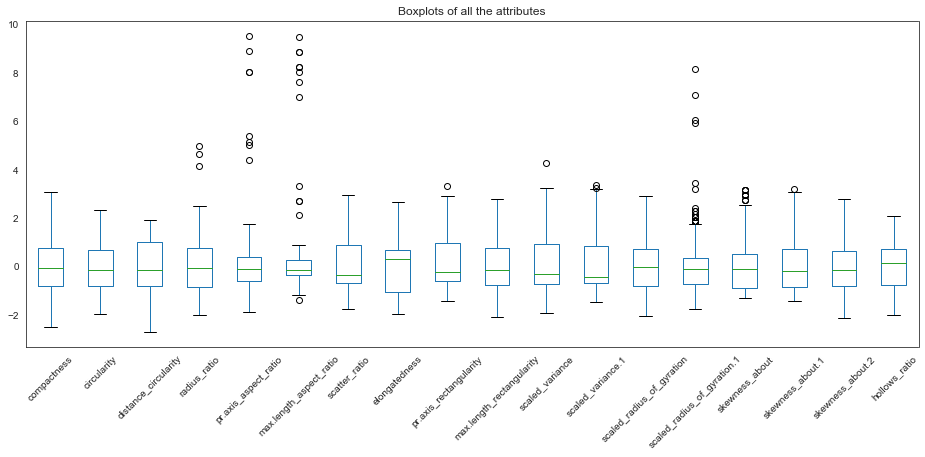

In [14]:
# Checking the data distributions of attributes using the entire dataframe

pd.concat([train,test], axis = 0).plot(kind = 'box', rot=45, figsize=(16,6), title = 'Boxplots of all the attributes')
plt.show()

In [15]:
def fit_n_print(model, X_train, X_test, y_train, y_test):  # take the model, train data and test data as input
    from sklearn.metrics import confusion_matrix
    from sklearn.model_selection import cross_val_score

    
    model.fit(X_train, y_train)   # fit the model using the train data

    pred_test = model.predict(X_test)     # model predictions on the test data

    accuracy = round(model.score(X_test, y_test), 3)   # accuracy on the test data

    a = confusion_matrix(y_test, model.predict(X_test)).diagonal() #number of instances where predictions were right(class-wise)
    
    b = y_test.value_counts().sort_index()  # value counts of classes ( sort index to match the confusion matrix)
    
    scores = round(a/b, 3)   # proportion of correct predictions for every class
    
    c = y_test.unique(); c.sort()  # sorted class labels
    
    metrics = dict(zip(c,scores))
    metrics['Accuracy_overall'] = accuracy
    metrics['CV_score'] = round(cross_val_score(model, X_train, y_train, cv=10).mean(), 3)
    
    
    
    return metrics   # returns the dictionary metrics which holds all the metrics computed above

In [16]:
# Classification model using all the attributes in the data set
svm = SVC(gamma= 'auto')

metrics = fit_n_print(svm, X_train, X_test, y_train, y_test)

print(f'Number of dimensions used to train the model: {X_train.shape[1]}')

Number of dimensions used to train the model: 18


In [17]:
model = SVC()

params = {'C': [0.01, 0.1, 0.5, 1, 2, 4, 6, 8, 10], 'kernel': ['linear', 'rbf'], 'gamma' : ['auto', 'scale' ]}

model1 = GridSearchCV(model, param_grid=params, cv = 10, iid = False)

model1.fit(X_train, y_train)

print(f"Best Hyper Parameters:\n\n{model1.best_params_}")

Best Hyper Parameters:

{'C': 8, 'gamma': 'auto', 'kernel': 'rbf'}


C:\Users\Drogon\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


In [18]:
svm = SVC(C = 8, gamma = 'auto', kernel = 'rbf')

metrics = fit_n_print(svm, X_train, X_test, y_train, y_test)

Let's create Principle Components out of the attributes

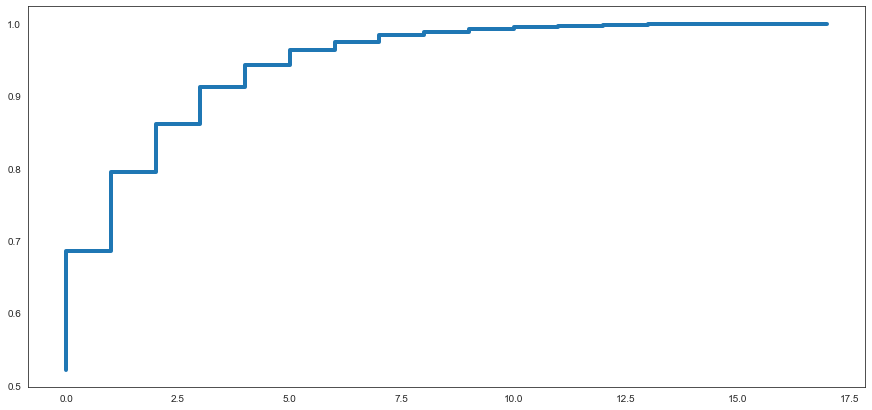

[0.5215939  0.68528628 0.79499759 0.86099374 0.9123263  0.94309231
 0.96294501 0.97512244 0.98351627 0.98874074 0.99248017 0.99486221
 0.99674898 0.99804741 0.99891875 0.99963358 0.99997836 1.        ]


In [19]:
pca = PCA().fit(X_train)

cummulative_variance = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize= (15,7))
plt.step(x = list(range(18)), y=cummulative_variance, linewidth = 4)
plt.show()
print(cummulative_variance)

**Looks like we need 9 principle components if we were to lose at most, 2% of the information in the data**

In [20]:
pca = PCA(.98)  # PCA object, which when fitted will generate principle components such that they capture 98% of the variance 

pca = pca.fit(X_train)

X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)


In [21]:
print(f'''Total number of dimensions in the dataset: {X_train.shape[1]}\n
Number of dimensions after PCA: {X_train_pca.shape[1]}\n
Dimensions reduced by {100*X_train_pca.shape[1]/X_train.shape[1]}%''')


Total number of dimensions in the dataset: 18

Number of dimensions after PCA: 9

Dimensions reduced by 50.0%


In [22]:
# Training an SVC using the PCs instead of the actual attributes 

svm = SVC(C = 8, gamma = 'auto', kernel = 'rbf')

metrics_pca = fit_n_print(svm, X_train_pca, X_test_pca, y_train, y_test)
metrics_pca

{'bus': 0.982,
 'car': 0.953,
 'van': 0.92,
 'Accuracy_overall': 0.953,
 'CV_score': 0.956}

In [23]:
model = SVC()

params = {'C': [0.01, 0.1, 0.5, 1, 2, 4, 6, 8, 10], 'kernel': ['linear', 'rbf'], 'gamma' : ['auto', 'scale' ]}

model1 = GridSearchCV(model, param_grid=params, cv = 10, iid = False)

model1.fit(X_train_pca, y_train)

print("Best Hyper Parameters:\n", model1.best_params_)

Best Hyper Parameters:
 {'C': 8, 'gamma': 'scale', 'kernel': 'rbf'}


C:\Users\Drogon\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


In [24]:
svm = SVC(C = 8, gamma = 'scale', kernel = 'rbf')

metrics_pca = fit_n_print(svm, X_train_pca, X_test_pca, y_train, y_test)
metrics_pca

{'bus': 0.964,
 'car': 0.953,
 'van': 0.98,
 'Accuracy_overall': 0.962,
 'CV_score': 0.962}

# Result

In [25]:
result = pd.DataFrame(metrics, index = ['Using all 18 dimensions'])
result.loc['Using 9 principle components'] = metrics_pca
result

bus    car   van  Accuracy_overall  CV_score
Using all 18 dimensions       0.964  0.963  0.96             0.962     0.975
Using 9 principle components  0.964  0.953  0.98             0.962     0.962

# Conclusion:

***We got almost the same perfromance from SVC when we used all the attributes from the data as it is, and when we derived 9 principle components from the 18 attributes, reducing our feature space by 50%***

# Additional task:  Clustering



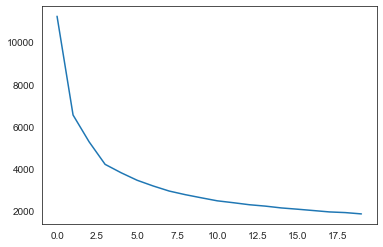

In [26]:
from sklearn.cluster import KMeans

data = X_train_pca.copy()     # Create a copy of the pc train array to later append the clusters to

ssd = []
for num_clusters in list(range(1,21)):   # get the sum of squared distances for different number of clusters
    model_clus = KMeans(n_clusters = num_clusters, max_iter=50)
    model_clus.fit(data)    
    ssd.append(model_clus.inertia_)

plt.plot(ssd)

In [27]:
model_clus = KMeans(n_clusters = 3, max_iter=50)   # we picked three clusters looking at the plot above
model_clus.fit(data)


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=50,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [28]:
data = np.c_[data, model_clus.labels_]   # adding a column to our array which contains the cluster information

In [29]:
data_test = X_test_pca.copy()
data_test = np.c_[data_test, model_clus.predict(data_test)]     # same with the test set

In [30]:
svm = SVC(C = 8, gamma = 'auto', kernel = 'rbf')

metrics_clusters = fit_n_print(svm, data, data_test, y_train, y_test)    # model trained with data having cluster information
metrics_clusters

{'bus': 0.982,
 'car': 0.944,
 'van': 0.92,
 'Accuracy_overall': 0.948,
 'CV_score': 0.958}

- Cluster information hasn't made any significant difference 
- Let's change the hyperparameters to see if we can squeeze a bit more performance

In [31]:
model = SVC()

params = {'C': [0.01, 0.1, 0.5, 1, 2, 4, 6, 8, 10], 'kernel': ['linear', 'rbf'], 'gamma' : ['auto', 'scale' ]}

model1 = GridSearchCV(model, param_grid=params, cv = 10, iid = False)

model1.fit(data, y_train)

print("Best Hyper Parameters:\n", model1.best_params_)

Best Hyper Parameters:
 {'C': 4, 'gamma': 'scale', 'kernel': 'rbf'}


C:\Users\Drogon\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


In [32]:
svm = SVC(C = 10, gamma = 'scale', kernel = 'rbf')

metrics_clusters = fit_n_print(svm, data, data_test, y_train, y_test)
metrics_clusters

{'bus': 0.982,
 'car': 0.953,
 'van': 0.96,
 'Accuracy_overall': 0.962,
 'CV_score': 0.957}

 - Very slight insignificant improvement possibly due to random chance

In [33]:
import plotly.express as px
import plotly.graph_objs as go

fig = px.scatter_3d(x = data[:,0], y = data[:,1], z = data[:,2],
                    color = data[:,-1],
                    opacity= 0.7 )
fig.show()

- We can use the first three principal components to see how well the clusters are getting seperated

# Final Remarks:

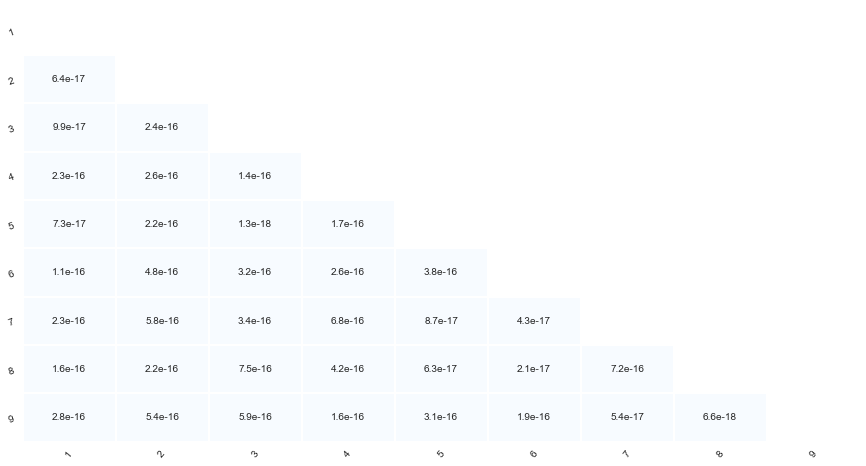

In [34]:
df_pca = pd.DataFrame(X_train_pca, columns=[1,2,3,4,5,6,7,8,9])

corr = abs(df_pca.corr()) # correlation matrix
lower_triangle = np.tril(corr, k = -1)  # select only the lower triangle of the correlation matrix
mask = lower_triangle == 0  # to mask the upper triangle in the following heatmap

plt.figure(figsize = (15,8))  # setting the figure size
sns.set_style(style = 'white')  # Setting it to white so that we do not see the grid lines
sns.heatmap(lower_triangle, center=0.5, cmap= 'Blues', annot= True, xticklabels = corr.index, yticklabels = corr.columns,
            cbar= False, linewidths= 1, mask = mask)   # Da Heatmap
plt.xticks(rotation = 50)   # Aesthetic purposes
plt.yticks(rotation = 20)   # Aesthetic purposes
plt.show()

- Since the Principle components are orthogonal to each other, there will be zero correlation amongst them
- The numbers are miniscule correlation values which have no significance
- Hence we go rid of multicollinearity also when we reduced the dimensions in the data using PCA

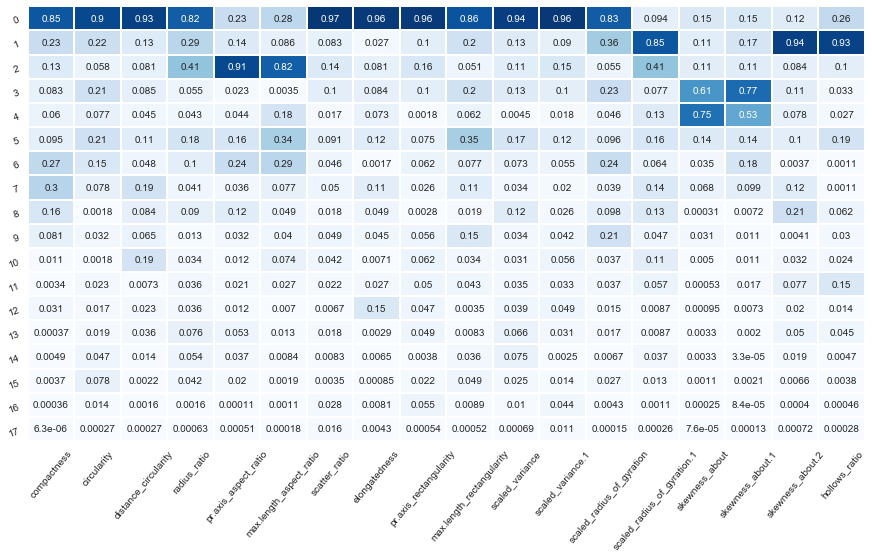

In [35]:
pca = PCA()

PCs = pca.fit_transform(X_train)

correlation = pd.DataFrame(np.corrcoef(X_train.values, PCs, rowvar= False )[18:36,0:18], # a dirty workaround to get the correlation dataframe
                           columns= X_train.columns,
                           index = list(range(18)))


plt.figure(figsize = (15,8))  # setting the figure size
sns.set_style(style = 'white')  # Setting it to white so that we do not see the grid lines

sns.heatmap(abs(correlation), center=0.5, cmap= 'Blues', annot= True,
            cbar= False, linewidths= 1)   # Da Heatmap


plt.xticks(rotation = 50)   # Aesthetic purposes
plt.yticks(rotation = 20)   # Aesthetic purposes
plt.show()

- The above heatmap shows the correlation of each principle component with each of the attributes
- We can observe that as the traverse from the first principle component to the 18th, the correlation between the component and the attributes keep reducing
- The arrtibutes that were missed out by the first component were captured by the following components